## Introduction

This is an extremely niche topic, especially in the context or Arma 3. I'll do my best to make it understandable with little prior knowledge about the topic. After a brief overview on the subject, this notebook concentrates on the actions performed on the extracted data using Python and SQL via Python's sqlite3 library. It doesn't explain the data extraction itself in full detail. (from Arma 3 to the `.sqf`-files in `Python/src/fired shots sqf`-folder).


#### Technical aspects covered in this notebook
* Modifying ndarray-shaped data created in another program (Arma 3 /`.sqf`) using Python
* Importing data from a text file to a local SQL database using Python (`sqlite3` library)
  * In SQL: Basic data definition, manipulation and queries
  * i.e. Table creation, inserting to, altering & updating tables, deleting, queries
    * Dynamicly using Python
* Cleaning data using Python (in this case by removing a cluster using `sklearn.cluster.Kmeans`)
* Fitting data to a continuous distribution (`scipy.stats.rayleigh`)
* Visualizing data using `matplotlib.pyplot` (`pandas.plot`)
* Pandas DataFrames (as the data structure used in Python)

### Topic & Motivation
Arma 3 is a sandbox military simulation / shooter game with immense modding support which means the players may program the game to their liking in about every aspect. This modability is also how I extracted the data in Arma 3 using `fn_calculate_bullet_offset.sqf`. </br>

The [Advanced_ballistics module of ACE3 modification](https://github.com/acemod/ACE3/tree/master/addons/advanced_ballistics) is an example of what modded Arma 3 has to offer. Using it gave me an idea of basically storing the impacts of shots in Arma 3, and then visualizing them in Python. I'll explain the data in further detail later during the steps.

As it became apparent there's no point in pasting `.sqf` arrays with tens of thousands of characters to a Python file, I decided to add **an extra challenge to this project by storing the data from text files to a SQL database**, albeit a local one at that :). I had taken the basic course about SQL but it consentrated on queries and ER diagrams, and was strictly limited to a SQL environment without covering *the actual use* of those databases. Hence, I wanted to experiment interacting with a SQL database using another programming language while keeping the `.py` files clean of the data from Arma 3.

### Intention

First, the data is exported to the SQL database, which is a learning experience for one, and a convenience for other.

After the impacts are in the database, the impact data is explored. The exploration entails
* Standardazing the data (in this case by shifting x and y columns so that the mean of both is zero)
* Visual exploration for anomalies
* Data cleaning using clustering & KMeans
* Determining the normality of impact groupings
* **Comparing the precision of the weapons**

## Preparations

### Imports & Global Vars

First, we need to import libraries & functions from the project folder for data processing and visualization. </br>
Global variables are also defined. `DB_PATH` and `TABLE_NAME` will be used through the code!

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as stats
# from sklearn.cluster import KMeans  # KMeans may be used later. There's a separate import for it

import sqlite3

from sqlite3_funcs import sqlite_to_df, initialize_db_n_table, insert_into_DB, delete_from_table, standardize_column, update_dist_to_mean
from data_processing_funcs import different_bin_counts

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams["figure.dpi"]=80

DB_PATH = "fired_shots.db"
print("DB path:  ", DB_PATH)
TABLE_NAME = "shots"


DB path:   fired_shots.db


### Initialization of the database

The database & table in it are initialized next. The table is created with the following query where `TABLE_NAME = shots`. </br>
</br>
Note SQLite is used & some of the definitions get simplified based on the chart [here at 3.1.1. Affinity Name Examples](https://www.sqlite.org/datatype3.html). It doesn't affect the functionality of the code.
```sql
CREATE TABLE shots (
    id INT PRIMARY_KEY,             -- A unique ID per a shot
    x DECIMAL(7,6),                 -- The horizontal error, from the direction the gun was facing to the impact.
    y DECIMAL(7,6),                 -- The vertical error, from the direction the gun was facing to the impact.
    dist_from_mean DECIMAL(8,7),    -- i.e. sqrt((mean_x^2-x^2)+(mean_y^2-y^2))   Calculated  in fn_calculate_bullet_offset
    firing_range INT,               -- Distance from the shooter to the target, meters
    weapon VARCHAR(10),             -- Arma 3 classname of the weapon used for the shot
    weap_short VARCHAR(6),          -- A shorter name for weapon.
    ammo_type VARCHAR(6),           -- Arma 3 classname of the ammo used for the shot
    data_batch INT                  -- For identifying which file the shot is from
)
```

Inspect the classifying columns of the database </br>

In [3]:
# If the project is run for the first time, initialize the database!

if "initialize_stuff" not in locals():
    initialize_stuff = True
    # Initialize_stuff gets set to False later.
    # I.e., the database can't be accidentally re-initialized 
    # even if this cell is rerun unless the program is properly restarted 

try:
    initialize_db_n_table(drop_if_exists=initialize_stuff, table_name=TABLE_NAME, database_path=DB_PATH)
    print("Database initialized successfully")
except sqlite3.OperationalError:
    print(f'The database with a table "{TABLE_NAME}" exists already & you decided to not drop the table!')

database_path in initilaize_db fired_shots.db
Table "shots" in "fired_shots.db" has currently 2022 rows
Table "shots" in "fired_shots.db" has currently 3968 rows
Table "shots" in "fired_shots.db" has currently 17985 rows
Table "shots" in "fired_shots.db" has currently 20000 rows
Database initialized successfully


### Add extra data batches

The following batches that aren't included in `initialize_db_n_table`. I recommend these are also added, though. The last addition, in particular adds more M110 values

In [4]:
# Once the database & sheet have been initialized, 
# you can also insert data without separate initialization

if initialize_stuff:
    # AXMC at 600m
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    insert_into_DB("fired shots sqf/axmc_ball_600_raw.sqf",     TABLE_NAME, 600, "SPS_AI_AXMC338_27_PB_F", "axmc", "B_SPS_338_300gr_Berger_OTM", data_batch_num, DB_PATH)
    print("The latest data batch:", data_batch_num)

    # SVDM at 600m
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    insert_into_DB("fired shots sqf/svdm_ball_600_raw.sqf", TABLE_NAME, 600, "rhs_weap_svdp_npz", "svdm", "rhs_B_762x54_7N1_Ball", data_batch_num, DB_PATH)
    print("The latest data batch:", data_batch_num)

    # SR16 at 600m
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    insert_into_DB("fired shots sqf/sr1614_5_ball_600_raw.sqf", TABLE_NAME, 600, "Tier1_SR16_Carbine_Mod2_MFT_FDE", "sr16", "rhs_ammo_556x45_Mk262_Ball", data_batch_num, DB_PATH)
    print("The latest data batch:", data_batch_num)

    # M110 at 1100m
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    insert_into_DB("fired shots sqf/m110_ball_1100_raw2.sqf", TABLE_NAME, 1100, "Tier1_M110k5_ACS_65mm", "m110", "Tier1_65CM_Ball", data_batch_num, DB_PATH)
    print("The latest data batch:", data_batch_num)
    
    # Another SR16 at 600m
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    insert_into_DB("fired shots sqf/sr1614_5_ball_600_raw2.sqf", TABLE_NAME, 600, "Tier1_SR16_Carbine_Mod2_MFT_FDE", "sr16", "rhs_ammo_556x45_Mk262_Ball", data_batch_num, DB_PATH)
    print("The latest data batch:", data_batch_num)
    
    # AAAnd another Another SR16 at 600m
    data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
    data_batch_num = data_batches_df.max().iloc[0] + 1
    insert_into_DB("fired shots sqf/sr1614_5_ball_600_fix.sqf", TABLE_NAME, 600, "Tier1_SR16_Carbine_Mod2_MFT_FDE", "sr16", "rhs_ammo_556x45_Mk262_Ball", data_batch_num, DB_PATH)
    print("The latest data batch:", data_batch_num)
    
initialize_stuff = False

Table "shots" in "fired_shots.db" has currently 21000 rows
The latest data batch: 4
Table "shots" in "fired_shots.db" has currently 23045 rows
The latest data batch: 5
Table "shots" in "fired_shots.db" has currently 25067 rows
The latest data batch: 6
Table "shots" in "fired_shots.db" has currently 27040 rows
The latest data batch: 7
Table "shots" in "fired_shots.db" has currently 36739 rows
The latest data batch: 8
Table "shots" in "fired_shots.db" has currently 43916 rows
The latest data batch: 9


## Data Exploration

### Overview to the data

The unit of measurement in this data is milliradians/MRADs. The x and y columns are the error of an impact from the position the gun was aiming at the time the shot was fired in Arma 3 in their respective axes. Without going too technical, it is important to notethe position where the gun is aiming and the mean point of impacts can be a different value

E.g. if there were only two impacts `imps=[[0.25,0.3],[-0.15,0.1]]]`
* The direction the gun faces is origin `[0,0]`
* The first impact deviated 0.25 MRADs to the right AND 0.3 MRADs up from the direction the gun was facing.
* The mean point of impacts is `[avg(0.25,-0.15), avg(0.3,0,1)] = [0.05,0.2]` --> The mean point of impacts deviated 0.05 MRADs to right and 0.2 MRADs up

### Initial query

A broad SELECT query is conducted to get an overview of the data we're working with. The data in `{TABLE_NAME} (shots)` is grouped by their batch.

In [5]:
q = '''
SELECT weapon, weap_short, firing_range, data_batch, COUNT(id) as count, AVG(dist_from_mean) as avg_impact_distance_from_mean, AVG(x) as x_mean, AVG(y) as y_mean
FROM shots
GROUP BY data_batch
--ORDER BY avg_impact_distance_from_mean
'''

# Get an overview of the data
sqlite_to_df(q, DB_PATH)

,weapon,weap_short,firing_range,data_batch,count,avg_impact_distance_from_mean,x_mean,y_mean
0,Tier1_M110k5_ACS_65mm,m110,1100,0,2022,0.046114,0.272448,-0.373615
1,SPS_AI_AXMC338_27_DE_F,axmc,1100,1,1946,0.054874,-0.231472,0.125740
2,srifle_LRR_camo_F,m200,1100,2,14017,0.059883,0.231302,-0.136974
3,rhs_weap_XM2010,m2010,1100,3,2015,0.097753,-0.273567,0.486374
4,SPS_AI_AXMC338_27_PB_F,axmc,600,4,1000,0.070663,0.147117,0.064716
5,rhs_weap_svdp_npz,svdm,600,5,2045,0.416056,0.261440,0.005645
6,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,6,2022,0.243675,0.281618,0.266969
7,Tier1_M110k5_ACS_65mm,m110,1100,7,1973,0.045839,-0.225142,-0.468393
8,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,8,9699,0.263482,0.278485,0.223513
9,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,9,7177,0.147018,0.279546,-0.214801


### Standardizing x- and y-axes

Currently the x and y columns of the table aren't standardized in the sense that mean(x) = 0.

SQL's `AVG()` is used to make the edit straight into the database, as the original offsets from the origin aren't relevant when comparing weapons to each other. The original offsets depend on the way the weapon's scope was adjusted when the shots were fired & the data was gathered. If the scope was adjusted so that the bullets will and 0.5 MRADs to the right, the mean point of impact will also initially be 0.5 MRADs to the right.

In [6]:
data_batches_df = sqlite_to_df(f"SELECT DISTINCT data_batch FROM {TABLE_NAME}", DB_PATH)
# from 0 to the last data_batch. The addition is required, as teh end of range is exclusive
for data_batch in range(0,data_batches_df.max().iloc[0]+1):
    standardize_column("x", f"WHERE data_batch = {data_batch}", TABLE_NAME, DB_PATH)
    standardize_column("y", f"WHERE data_batch = {data_batch}", TABLE_NAME, DB_PATH)

Check the batches after the standardization. </br>
</br>
The means are now almost equal to zero. The remaining error is insignificant.

In [7]:
q = '''
SELECT weapon, weap_short, firing_range, data_batch, COUNT(id) as count, AVG(x) as x_mean, AVG(y) as y_mean
FROM shots
GROUP BY data_batch
'''

# Get an overview of the data
sqlite_to_df(q, DB_PATH)

,weapon,weap_short,firing_range,data_batch,count,x_mean,y_mean
0,Tier1_M110k5_ACS_65mm,m110,1100,0,2022,-1.850097e-16,2.761282e-16
1,SPS_AI_AXMC338_27_DE_F,axmc,1100,1,1946,-4.257471e-17,-1.663623e-16
2,srifle_LRR_camo_F,m200,1100,2,14017,6.515343e-16,5.996369e-16
3,rhs_weap_XM2010,m2010,1100,3,2015,-1.952946e-16,5.878948e-17
4,SPS_AI_AXMC338_27_PB_F,axmc,600,4,1000,-1.215694e-16,5.982020e-17
5,rhs_weap_svdp_npz,svdm,600,5,2045,2.330383e-16,7.021007e-17
6,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,6,2022,3.795458e-17,-2.054077e-16
7,Tier1_M110k5_ACS_65mm,m110,1100,7,1973,9.542122e-17,-4.869113e-16
8,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,8,9699,-5.460113e-16,-1.511948e-16
9,Tier1_SR16_Carbine_Mod2_MFT_FDE,sr16,600,9,7177,-1.276981e-17,3.033893e-16


### Querying SQL to pd.DataFrames

Let's compare the precision of the four guns which have data from `firing_range` of 1100! </br>
</br>
Start by querying the tables from the database to Pandas DataFrames using sqlite3 & getting different bin counts for the histogram </br>
</br>
The shorter names work perfectly here to classify the guns based on their ballistic performance. </br>
E.g., each gun with `weap_short="axmc"` have the same ballistic properties! </br>
Only the Arma 3 class name (`weapon`) is slightly different. </br>
</br>
NB! In this case, grouping by `weap_short` combines the two different batches of m110!

In [8]:
# Create a query for the selected weapons

q = f"""
SELECT weap_short, COUNT(weap_short) as "Row count"
FROM {TABLE_NAME} 
WHERE firing_range=1100
GROUP BY weap_short
ORDER BY AVG(shots.dist_from_mean)
"""

iter_df = sqlite_to_df(q, DB_PATH)
iter_df

,weap_short,Row count
0,m110,3995
1,axmc,1946
2,m200,14017
3,m2010,2015


In [9]:
dfs = {}            # The actual dataframes based on the query
bin_cnts = {}       # Histogram bin counts per df

firing_range = 1100

for weap_short in iter_df["weap_short"].to_list():
    
    # Note the firing_range is sepcified here, too.
    
    # data_batch is selected for tracking potential issues
    q = f'''
    SELECT id, x, y, dist_from_mean, data_batch
    FROM shots
    WHERE (weap_short = "{weap_short}" AND firing_range = {firing_range})
    '''
    dfs[weap_short] = sqlite_to_df(q, DB_PATH)
    
    bin_cnts[weap_short] = different_bin_counts(dfs[weap_short]["dist_from_mean"].to_numpy())
    
    print(dfs[weap_short].shape)

(3995, 5)
(1946, 5)
(14017, 5)
(2015, 5)


### Visual exploration
Let's start the data inspection by checking the Quantal-Quantal plot of the x- and y-values of the dataframe. The assumption is both x- and y-components of the impacts are normally distributed.

`statsmodels.graphics.gofplots.qqplot` can be used, but `scipy.stats` can be used, too, without requiring an extra library

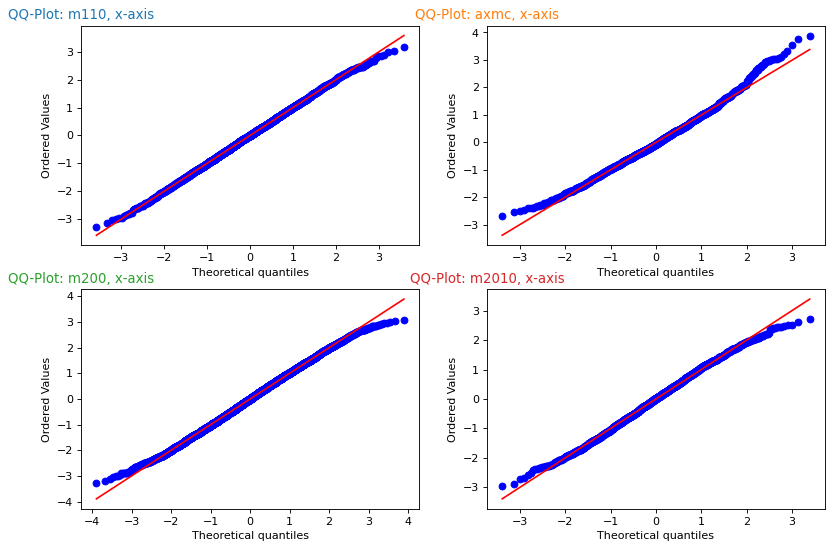

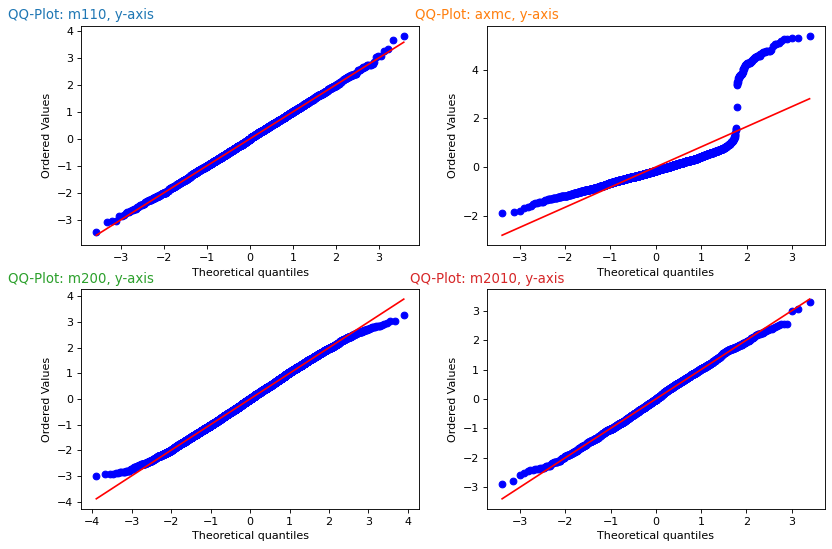

In [10]:

figx, axsx = plt.subplots(nrows=2,ncols=2)
figy, axsy = plt.subplots(nrows=2,ncols=2)

for i, (weap_short, axx_i, axy_i) in enumerate(zip(dfs, axsx.flatten(), axsy.flatten())):
    
    # The x and y values are half way towards standardization: 
    # They still must be divided with their standard deviation
    
    z_x = dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])
    z_y = dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])
    
    stats.probplot(z_x, dist="norm", plot=axx_i)
    stats.probplot(z_y, dist="norm", plot=axy_i)
    
    axx_i.set_title(f"QQ-Plot: {weap_short}, x-axis", c=f"C{i}", position=[0,0])
    axy_i.set_title(f"QQ-Plot: {weap_short}, y-axis", c=f"C{i}", position=[0,0])
    
    #qqplot(dfs[weap_short]["x"], line="s", ax=axx_i) #, c=f"C{i}")  Apparently the color can't be implemented
    #qqplot(dfs[weap_short]["y"], line="s", ax=axy_i) #, c=f"C{i}")  Apparently the color can't be implemented


plt.show()

M110, M200 and M2010 seem to follow the normal distribution give the relatively thin tails of the QQ-plot.

Let's continue the inspection by checking how far the shots landed from the mean points of impacts using a histogram. Here AXMC should deviate from the rest.

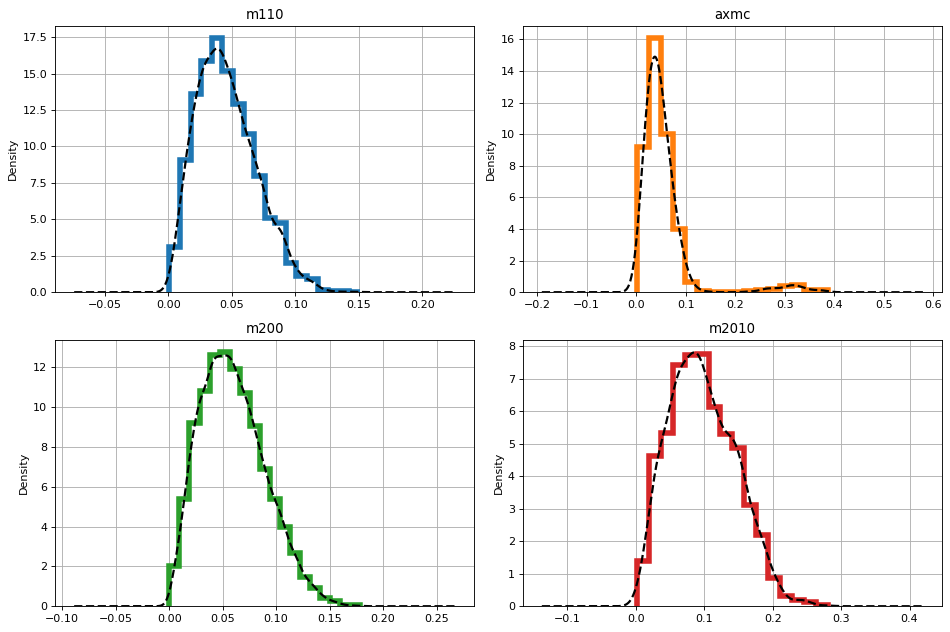

In [11]:
fig, axs = plt.subplots(tight_layout=True, nrows=2, ncols=2)

for i, (weap_short, ax_i) in enumerate(zip(dfs, axs.flatten())):
    dfs[weap_short]["dist_from_mean"].plot.hist(
        bins=bin_cnts[weap_short]["doane"],
        histtype="step",
        linewidth=5,
        color=f"C{i}",  # Color based on index i
        ax=ax_i,
        density=1,
        title=weap_short)
    
    dfs[weap_short]["dist_from_mean"].plot.density(
        linewidth=2,
        ls="--",
        color="k",  # black
        ax=ax_i,
        title=weap_short)
    ax_i.grid(True)


M110 seems to be the most accurate so far but AXMC data has some significant outliers, as expected based on the QQ-plots! </br>
</br>
Let's investigate it further by taking a separate scatter plot of AXMC to get a better understanding of the situation!.

<AxesSubplot:xlabel='x', ylabel='y'>

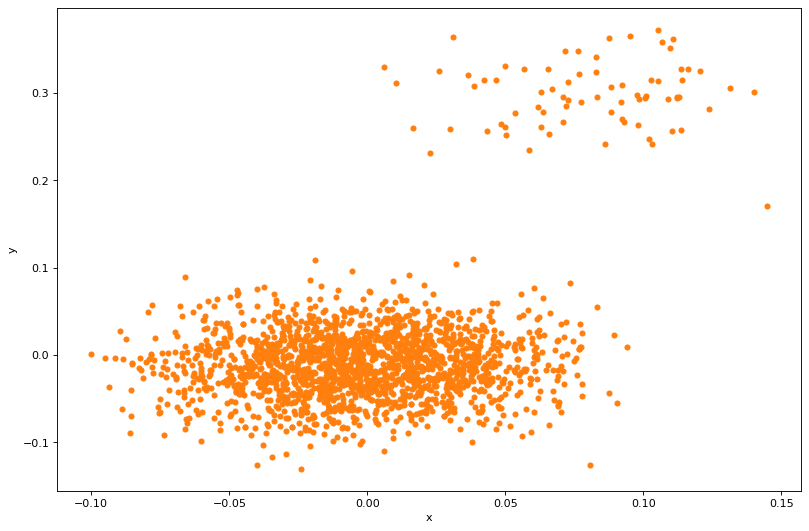

In [12]:
dfs["axmc"].plot.scatter("x", "y", c="C1")

There's clearly another cluster in the data that must be addressed!

Otherwise, the QQ-plots seem about normal and don't require further investigation.

## Data Cleaning

### Overview
There are dozens of data points some 0.3 MRADs higher and slightly to the right from the mean. </br>
All impacts should land in one grouping, as malfunctions that would skew the dispersion aren't a thing in Arma. The issue is probably in the shot being fired before the barrel was pointing at the target.</br>
</br>
The faulty values will be cleaned. In this case, they aren't needed in the database, either!
</br>
</br>

In this case, no statistical/ML methods are necessary for cleaning.</br>
Instead we only really need to get the y-value of the rightmost impact and delete all impacts whose y-value is equal to or higher than its.</br>
</br>
However, a solution using KMeans clustering can be implemented for the sake of an example & a more general case.

In [13]:
# Choose
clustering = True                      # Clustering method vs. manually taking the values higher than the rightmost impact
delete_errorous_rows_from_db = True    # Delete the errorous values from the DB or not

#### Option 1: Clustering

The more general solution to the problem. Works even if the rightmost value wasn't the value with the lowest y-value of the coordinates we want gone

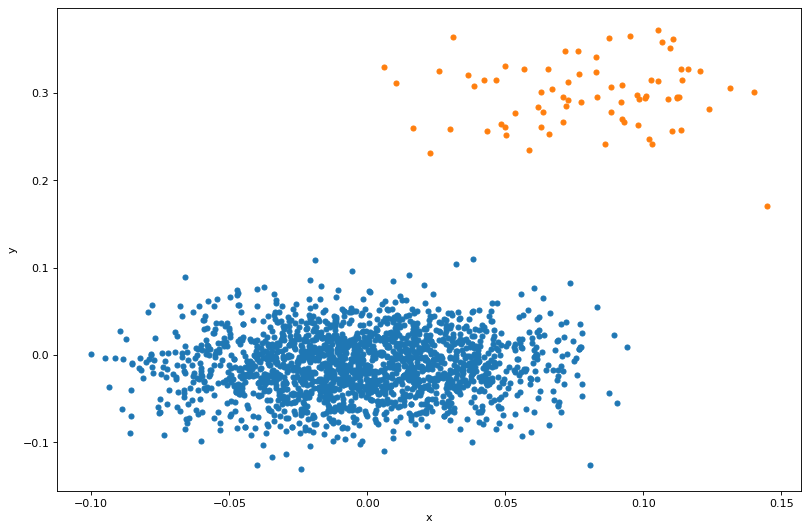

In [14]:
if clustering:
    from sklearn.cluster import KMeans

    # There are two distinguishable clusters
    km = KMeans(n_clusters=2)

    pred = km.fit_predict(dfs["axmc"][["x","y"]])

    # Create a separate df to avoid dataframes in dfs-dict to have different column count
    df_axmc = dfs["axmc"][["id","x","y","data_batch"]]
    df_axmc["clusters"] = pred

    # C stands for both color and cluster here
    df_axmc_c0 = df_axmc[df_axmc.clusters==0]
    df_axmc_c1 = df_axmc[df_axmc.clusters==1]

    # Plot the clusters
    only_ax = df_axmc_c0.plot.scatter("x", "y", c="C0")
    df_axmc_c1.plot.scatter("x", "y", c="C1", ax=only_ax)
    
    # Select the cluster with the smaller size as the errorous cluster
    errorous_cluster = min([df_axmc_c0, df_axmc_c1], key=lambda df: df.size)
    
    # Tuple is used, as tuple's syntax is similar to SQL's WHERE IN syntax
    # e.g. WHERE column_name IN (value1, value2, ...); 
    errorous_cluster_ids = tuple(errorous_cluster["id"].to_numpy())
    
    # Del_condition for delete_from_table would be
    del_condition = f"(id IN {errorous_cluster_ids})"
    

#### Option 2: Greater y than rightmost point

Based on the visualization, we can easily select the points with y-val greater than the rightmost point, as luckily all those are part of the other cluster

In [15]:
if not clustering:

    max_y_row_i = dfs["axmc"]["x"].idxmax()
    max_y_row = dfs["axmc"].iloc[max_y_row_i]
    
    # Once the row (coordinate) has been defined, the remaining values can be easily obtained
    y_val = max_y_row["y"]
    faulty_data_batch = max_y_row["data_batch"]


With this information, as the TALBE_NAME (default "shots") has already been standardized, we can delete all rows from the table with an y-value higher or equal to 0.170106 with the same data batch as the faulty axmc data.

This method works only when the faulty data is all from the same batch, though!

In [16]:
if not clustering:
    del_condition = f"(data_batch = {faulty_data_batch} AND y >= {y_val})"

After the faulty data has been isolated, it may be deleted from the database. Even if it's not deleted, `dfs["axmc"]` must be updated to a new state. This can be done by either deleting the faulty data from the current DataFrame or by redefining it. In this case, it's redefined with a new SQL query.

If the data is deleted, the mean point of the remaining impacts also change.  

In [17]:

if delete_errorous_rows_from_db:
    delete_from_table(f"WHERE {del_condition}", TABLE_NAME, DB_PATH)
    
    # Now when rows are deleted from the table, the mean has also shifted.
    # Hence,
    delete_errorous_rows_from_db = False

    # "dist_to_mean" must be updated, as the mean shifts from the previous after row deletation!
    # TODO apply kuntoon!
    update_dist_to_mean(TABLE_NAME, DB_PATH, dfs["axmc"])
    standardize_column("x", f"WHERE data_batch = {data_batch}", TABLE_NAME, DB_PATH)
    standardize_column("y", f"WHERE data_batch = {data_batch}", TABLE_NAME, DB_PATH)


q = f'''
    SELECT id, x, y, dist_from_mean, data_batch
    FROM shots
    WHERE (weap_short = "axmc" AND firing_range = 1100 AND NOT {del_condition})
    '''
dfs["axmc"] = sqlite_to_df(q, DB_PATH)
print("fin")


fin


### Looking into normality of our data

After cleaning the data, apply a test for normality.

Shapiro-Wilk normality test is a commonly used one, but shouldn't be used if n>5000 due to being over-sensitive.

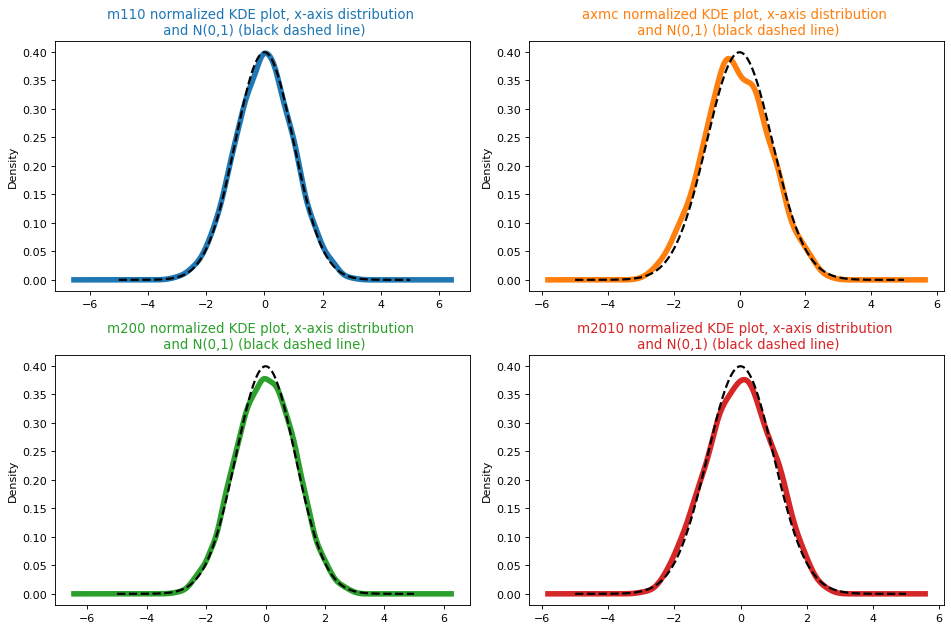

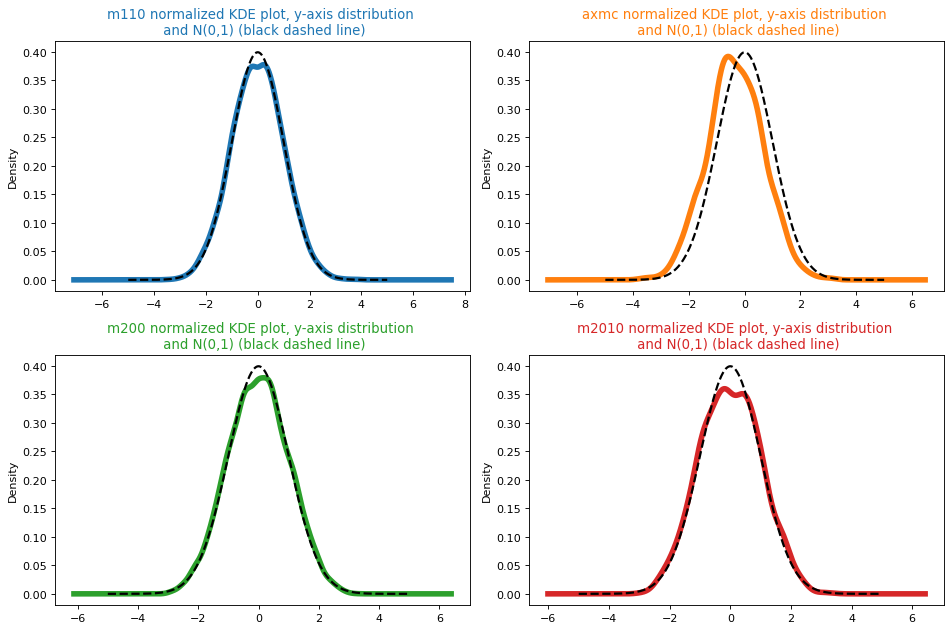

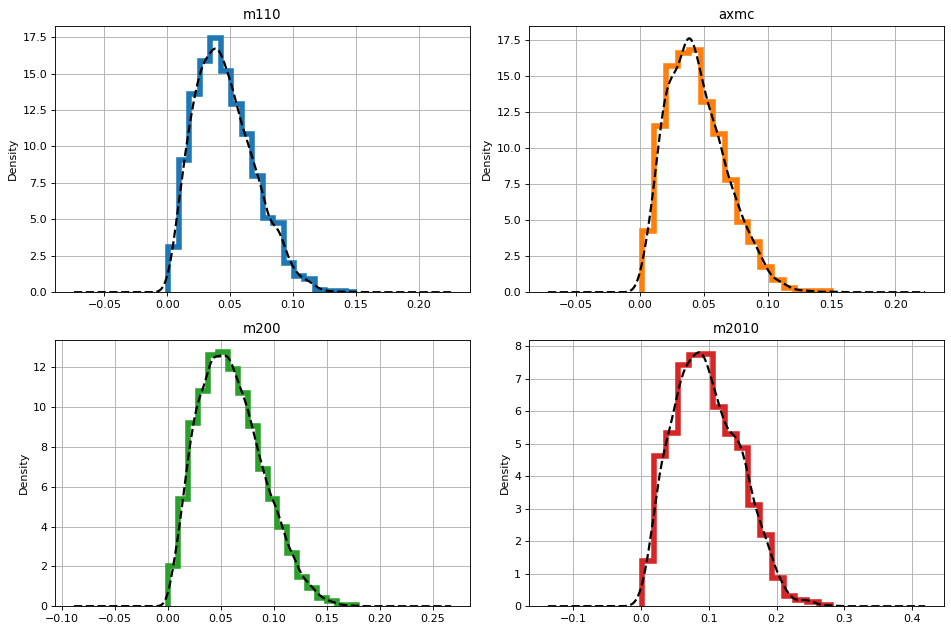

In [18]:
# x QQ-plot, y QQ-plot, histogram
figx, axsx = plt.subplots(tight_layout=True,nrows=2,ncols=2)
figy, axsy = plt.subplots(tight_layout=True,nrows=2,ncols=2)
figh, axsh = plt.subplots(tight_layout=True, nrows=2, ncols=2)


for i, (weap_short, axx_i, axy_i, axh_i) in enumerate(zip(dfs, axsx.flatten(), axsy.flatten(), axsh.flatten())):
    
    # The x and y values are half way towards standardization: 
    # They still must be divided with their standard deviation to be concidered "standardized"
    
    # norm. distr. z-value; mean is already 0, hence only div by std
    # z_x = dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])
    # z_y = dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])
    
    
    # Plot a density plot of standardized x and y (mu=0, sigma=1)
    (dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])).plot.density(ax=axx_i, c=f"C{i}", linewidth=5)
    (dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])).plot.density(ax=axy_i, c=f"C{i}", linewidth=5)
    
    x = np.linspace(-5,5,1000)
    norm_distr = stats.norm.pdf(x,0,1)
    axx_i.plot(x,norm_distr, linewidth=2, c="k", ls="--")
    axy_i.plot(x,norm_distr, linewidth=2, c="k", ls="--")

    #stats.probplot(z_x, dist="norm", plot=axx_i)
    #stats.probplot(z_y, dist="norm", plot=axy_i)
    
    axx_i.set_title(f"{weap_short} normalized KDE plot, x-axis distribution \n and N(0,1) (black dashed line)", c=f"C{i}")#, position=[0,0])
    axy_i.set_title(f"{weap_short} normalized KDE plot, y-axis distribution \n and N(0,1) (black dashed line)", c=f"C{i}")#, position=[0,0])
    
    
    #axx_i.set_title(f"QQ-Plot: {weap_short}, x-axis", c=f"C{i}", position=[0,0])
    #axy_i.set_title(f"QQ-Plot: {weap_short}, y-axis", c=f"C{i}", position=[0,0])
    
    # One statistical way to look into the normality of the data.
    # However
    # print(weap_short)
    # print("standardized x kurt test ", stats.kurtosis(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])))
    # print("standardized x skew test ", stats.skew(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])))
    # print("standardized x shapiro-wilk test ", stats.shapiro(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"]))[1])
    # print("standardized y kurt test ", stats.kurtosis(dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])))
    # print("standardized y skew test ", stats.skew(dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])))
    # print("standardized y shapiro-wilk test ", stats.shapiro(dfs[weap_short]["y"]/np.std(dfs[weap_short]["x"]))[1], "\n")
    
    # And lastly, the histogram & density plot
    dfs[weap_short]["dist_from_mean"].plot.hist(
        bins=bin_cnts[weap_short]["doane"],
        histtype="step",
        linewidth=5,
        color=f"C{i}",  # Color based on index i
        ax=axh_i,
        title=weap_short,
        density=1)
    
    dfs[weap_short]["dist_from_mean"].plot.density(
        linewidth=2,
        color="k",  # black
        ls="--",
        ax=axh_i,
        title=weap_short,
        grid=True)
    
    # Add 95 % Confidence Intervals purely based on the data gathered
    std_err = stats.sem(dfs[weap_short]["dist_from_mean"])

plt.show()

m110
standardized x kurt test  -0.1291177996744568
standardized x skew test  -0.023941210902213843
standardized x shapiro-wilk test  0.3994493782520294
axmc
standardized x kurt test  -0.283893178187812
standardized x skew test  0.0061867533473569285
standardized x shapiro-wilk test  0.03045906312763691
m200
standardized x kurt test  -0.2666820026089214
standardized x skew test  -0.011629344218961824
standardized x shapiro-wilk test  5.484318776893815e-08


c:\Users\Ari\anaconda3\envs\dataml100\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


m2010
standardized x kurt test  -0.42005249566863023
standardized x skew test  -0.05195346890477445
standardized x shapiro-wilk test  0.0004030897398479283


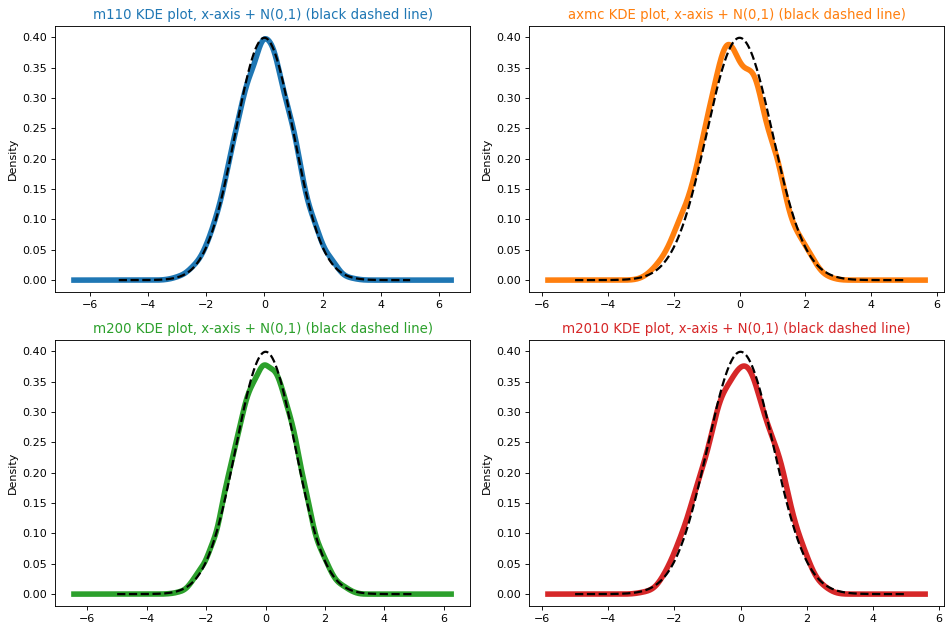

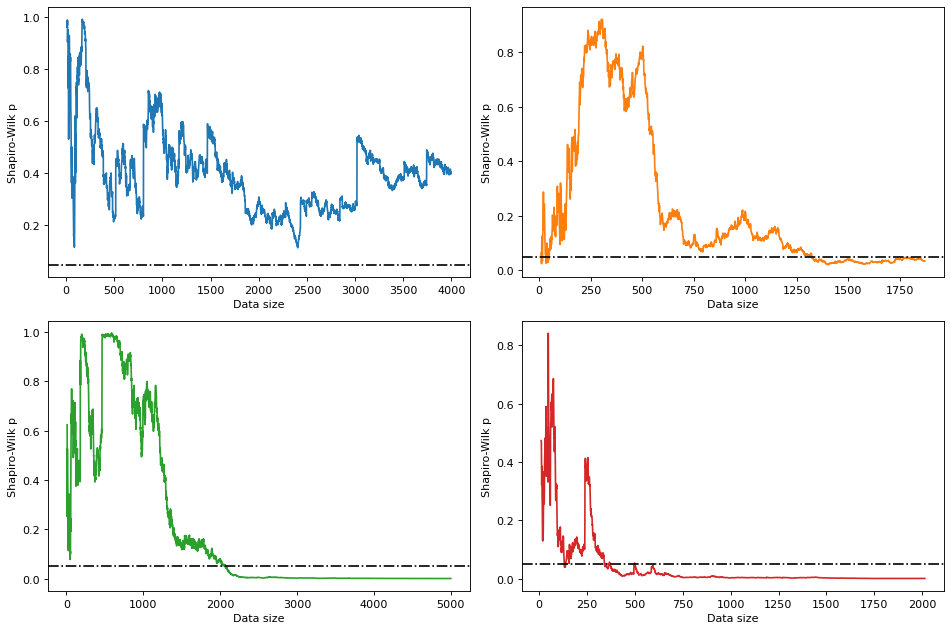

In [19]:
# x QQ-plot, y QQ-plot, histogram
figx, axsx = plt.subplots(tight_layout=True,nrows=2,ncols=2)
figx_sw, axsx_sw_test = plt.subplots(tight_layout=True,nrows=2,ncols=2)


for i, (weap_short, axx_i, axx_sw_i) in enumerate(zip(dfs, axsx.flatten(), axsx_sw_test.flatten())):
    
    # The x and y values are half way towards standardization: 
    # They still must be divided with their standard deviation
    
    # norm. distr. z-value; mean is already 0, hence only div by std
    # z_x = dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])
    # z_y = dfs[weap_short]["y"]/np.std(dfs[weap_short]["y"])
    
    
    # Plot a density plot of standardized x and y (mu=0, sigma=1)
    (dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])).plot.density(ax=axx_i, c=f"C{i}", linewidth=5)
    
    x = np.linspace(-5,5,1000)
    std_norm_distr = stats.norm.pdf(x,0,1)
  
    axx_i.plot(x,std_norm_distr, linewidth=2, c="k", ls="--")

    
    axx_i.set_title(f"{weap_short} KDE plot, x-axis + N(0,1) (black dashed line)", c=f"C{i}")#, position=[0,0])

    print(weap_short)
    print("standardized x kurt test ", stats.kurtosis(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])))
    print("standardized x skew test ", stats.skew(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"])))
    print("standardized x shapiro-wilk test ", stats.shapiro(dfs[weap_short]["x"]/np.std(dfs[weap_short]["x"]))[1])
    
    # Ok, but what kind of values does shapiro-wilk test provide with different sample sizes??
    
    
    
    if weap_short == "m200":
        sz = 5000
    else:
        sz = dfs[weap_short]["x"].size
        
    sw_test_results = np.empty((sz - 10, 2))
        
    for j in range(10, sz):
        #sample_x = dfs[weap_short]["x"].sample(i)
        sample_x = dfs[weap_short]["x"][0:j]
        sw_test_results[j-10] = (j, stats.shapiro(sample_x/np.std(sample_x))[1])


    axx_sw_i.plot(sw_test_results[:,0],sw_test_results[:,1], color=f"C{i}")
    axx_sw_i.set_xlabel("Data size")
    axx_sw_i.set_ylabel("Shapiro-Wilk p")
    axx_sw_i.axhline(y=0.05, color='k', linestyle='-.')
    
    # Add 95 % Confidence Intervals purely based on the data gathered
    std_err = stats.sem(dfs[weap_short]["dist_from_mean"])

plt.show()

So what can we get out of this normality testing, anyway?



### Fitting data to a continuous distribution (Chi² / Rayleigh)

If the distribution of x-axis and y-axis follow normal distribution, then the distribution of distances must also follow a known distribution. I tried different Chi2 fits first but they didn't prove to be practically useful with standardized data. 

Later I discovered Rayleigh distribution which appears to be a perfect match in this case in a practical sense, even though in our case the distribution of X and Y are independent from each other

m110's Rayleigh est: (0.00034302917843158197, 0.036311761008223344)
axmc's Rayleigh est: (0.0009201596753612939, 0.03512289421367586)
m200's Rayleigh est: (6.251835774268404e-05, 0.04735681853702593)
m2010's Rayleigh est: (0.0011811575460731552, 0.07626692671559884)


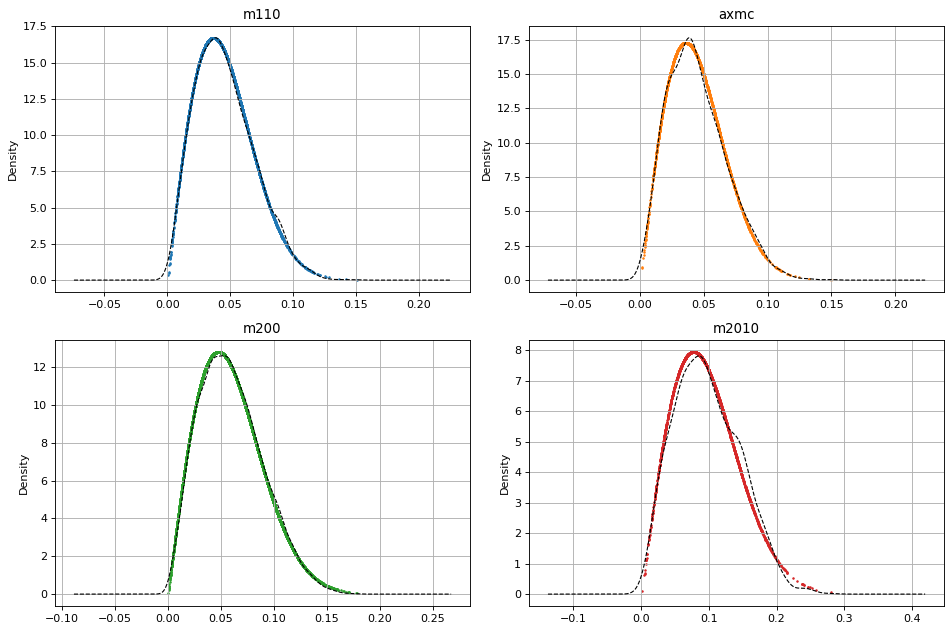

In [32]:
fig, axs_ray = plt.subplots(tight_layout=True,nrows=2,ncols=2)

for i, (weap_short, axs_ray_i) in enumerate(zip(dfs, axs_ray.flatten())):

    chi_x = np.linspace(0, 5,5000)
    x = np.linspace(-0.5,0.5,5000)
    y = np.linspace(-0.5,0.5,5000)  # doesn't rly matter I guess

    x_norm = stats.norm(np.mean(dfs[weap_short]["x"]), np.std(dfs[weap_short]["x"]))
    # x_norm = stats.norm.pdf(dfs[weap_short]["x"])
    # y_norm = stats.norm.pdf(dfs[weap_short]["y"])
    x_norm_pdf = x_norm.pdf(x)
    
    #idk = pd.Series(np.sqrt(x_norm_pdf**2 + y_norm_pdf**2))
    
    #idk.plot.density(ax=axs_ray_i)
    #axs_ray_i.set_xlim(-0.5,0.5)
    axs_ray_i.set_title(weap_short)
    
    (dfs[weap_short]["dist_from_mean"]).plot.density(
        linewidth=1,
        color="k",  # black
        ls="--",
        ax=axs_ray_i,
        title=weap_short,
        grid=True)
    
    ray_est = stats.rayleigh.fit((dfs[weap_short]["dist_from_mean"]), loc=0)  # loc=0 --> each PDF should start at (0,0)
    print(f"{weap_short}'s Rayleigh est: {ray_est}")
    ray_pdf = stats.rayleigh.pdf((dfs[weap_short]["dist_from_mean"]), ray_est[0], ray_est[1])
    axs_ray_i.scatter((dfs[weap_short]["dist_from_mean"]), ray_pdf, s=1.5, color=f"C{i}")


## Final Visualizations

In [ ]:
#Selects the length of the shortest dataframe in dfs dict
n = min([val.shape[0] for val in dfs.values()])
print("Minimum count of shots per df:", n)
seed = 1 # Seed for random_state of pd.DataFrame.sample

sample_dfs = {}
sample_dfs_bin_counts = {}

for weap_short in dfs:
    sample_dfs[weap_short] = dfs[weap_short].sample(n, random_state=seed)
    sample_dfs_bin_counts[weap_short] = different_bin_counts(sample_dfs[weap_short]["dist_from_mean"])


Minimum count of shots per df: 1872


Max distance between impacts for m2010: 0.5750732444523914
Mean of STDEVs for m2010: 0.08487046449369062 

Max distance between impacts for m200: 0.38063825249107913
Mean of STDEVs for m200: 0.05224208238903987 

Max distance between impacts for m110: 0.2980865331826404
Mean of STDEVs for m110: 0.04025107763520094 

Max distance between impacts for axmc: 0.2607222135710335
Mean of STDEVs for axmc: 0.03463739021496669 



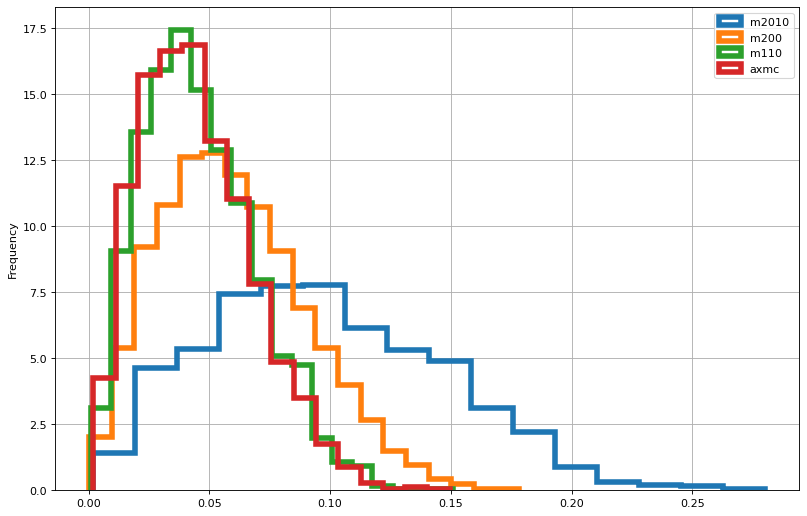

In [ ]:
from scipy.spatial.distance import cdist

# Re-sort the DataFrame based on the standard deviation of the distance_from_mean
# The ordered are 
sample_dfs_sorted = dict(sorted(dfs.items(), reverse=True, key=lambda item: np.std(item[1]["dist_from_mean"])))

# i -> index, weap_short -> key
for i, weap_short in enumerate(sample_dfs_sorted):
    
    if i == 0:
        only_ax = dfs[weap_short]["dist_from_mean"].plot.hist(
            bins=bin_cnts[weap_short]["doane"],
            histtype="step",
            linewidth=5,
            color=f"C{i}",
            density=1)

    else:
        only_ax = dfs[weap_short]["dist_from_mean"].plot.hist(
            bins=bin_cnts[weap_short]["doane"],
            histtype="step",
            linewidth=5,
            color=f"C{i}",
            density=1)
        
    print(f"Max distance between impacts for {weap_short}:", 
          np.max(
              cdist
              (dfs[weap_short].loc[:,("x","y")],
               dfs[weap_short].loc[:,("x","y")],
               "euclidean").flatten()))
    
    
    print(f"Mean of STDEVs for {weap_short}:", np.mean([np.std(dfs[weap_short]["x"]), np.std(dfs[weap_short]["y"])]), "\n")


only_ax.legend(list(sample_dfs_sorted))
only_ax.grid(True)

plt.show()

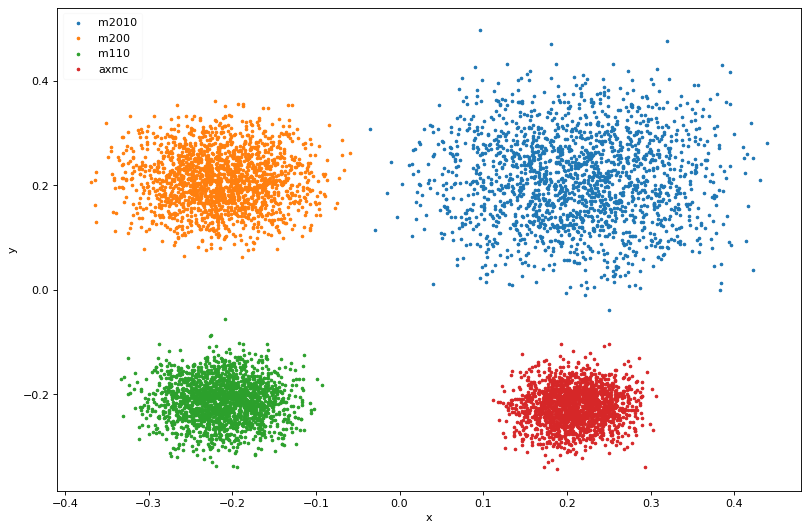

In [ ]:
# View the same data on a scatter plot

# I was thinking about the most elegant implementation & 
# decided to use polar coordinates to distribute the 
# scatter plots evenly around the origin on one axis
# here x = r*cos(theta) & y = r*sin(theta), r=radius, theta=angle

dist_from_origin = 0.3

for i, weap_short in enumerate(sample_dfs_sorted):
    
    # To get even split -- cluster per quarter
    #       45 degs + i*90 degs in radians
    angle = 0.25*np.pi + i*0.5*np.pi
    mean_pos_x = dist_from_origin*np.cos(angle)
    mean_pos_y = dist_from_origin*np.sin(angle)
    
    # Use concatenate to adjust the mean position of each cluster
    _df = pd.concat(objs=(sample_dfs[weap_short]["x"] + mean_pos_x, sample_dfs[weap_short]["y"] + mean_pos_y), axis=1)
    
    if i == 0:
        only_ax = _df.plot.scatter(
            "x", "y",
            s=5,
            color=f"C{i}")
    else:
        _df.plot.scatter(
            "x", "y",
            s=5,
            color=f"C{i}",
            ax=only_ax)

only_ax.legend(list(sample_dfs_sorted), loc="best", framealpha=0.11)

plt.show()